In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp

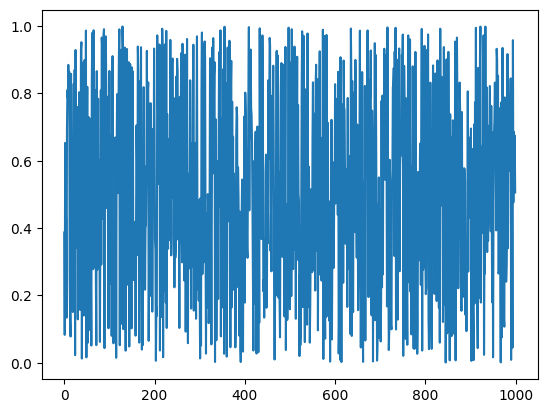

In [61]:
n = 20
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25
r= 5
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

sigma1 = 1
sigma2 = 0.1
sigmay = 0.1
gamma = 0.1
rho = 1

In [25]:
thetas = np.array([np.array([np.zeros(p)]).T])
for i in range(r): thetas[0][i] = 1
theta = np.array([np.zeros(p)]).T 
# thetas = np.vstack((thetas, theta))
theta.shape

(50, 1)

In [66]:
ssp(theta_0, gamma, sigma1, sigma2)

array([-29.76983151])

In [59]:
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

def ssp(theta, gamma, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [7]:
p = len(X[1])
n = len(X)
b = p + n
t = 1
niter = 10000
sigma_theta = 0.1
no_accept = 0
theta_0 = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
# thetas = np.array([np.array([np.zeros(p)]).T])
for i in range(r): theta_0[i] = 1

while t < niter:
    t += 1
    #symmetric random walk
    theta_c = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)*sigma_theta), (-1, 1))
    log_joint_candidate = ssp(theta_c, gamma, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
    # theta_0 = np.vstack(theta0, )

KeyboardInterrupt: 

In [8]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
    if i <= p-1:
        e = np.array([np.zeros(p)])
        e[0][i] = 1
        A = e * 1/sigma2
        if i == 0:
            Alist = A
            AtA = np.array([np.matmul(A.T, A)])
        else:
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
    else:
        X_t = X[i-p].reshape(1, p)
        A = X_t / sigmay
        Alist = np.vstack((Alist, A))
        AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

for t in range(niter):                                              #Beginning of Split Gibbs Sampling
    # print("Start of %sth iteration" % str(t))
    pi_z = 1
    for i in range(b):
        if i <= p-1:
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * (np.linalg.norm(np.matmul(Alist[i], theta)))**2/2)))
            w2 = 1 - w1
            # print(w1)
            mu = (1 - sigsig**2) * np.matmul(Alist[i], theta)
            sigmaz = 1 - sigsig**2
            pi_z = pi_z * (w1 * 0 + w2 * np.random.normal(mu, sigmaz))
            # print(pi_z)
            U = np.random.uniform()
            if U > w1:
                z = np.append(z, np.random.normal(mu, sigmaz))
            else:
                z = np.append(z, 0)
            Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
        else:
            z = np.append(z, y[i-p] / sigmay)
            Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
        print(pi_z)
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    # print(theta.shape)
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
    print("-------------------------------------------------------")

[0.58101149]
[0.17542292]
[0.24275546]
[-0.11674369]
[0.00619096]
[0.00420323]
[0.01118677]
[-0.00032467]
[0.00084121]
[-0.00096272]
[0.00025861]
[0.0001798]
[5.83313147e-06]
[5.13508225e-06]
[9.29844364e-06]
[2.11391128e-06]
[2.5950459e-06]
[1.75590127e-06]
[-9.70888312e-07]
[-1.55676724e-06]
[9.31104473e-08]
[2.28506125e-08]
[-2.26756476e-08]
[-2.34451684e-08]
[7.74774595e-09]
[6.34821549e-09]
[3.41327682e-09]
[-4.43560058e-09]
[3.00612021e-09]
[1.71160605e-09]
[1.82631984e-09]
[1.46959243e-09]
[5.82095449e-10]
[-1.09090101e-09]
[1.21183072e-09]
[1.21860412e-09]
[-8.13817825e-10]
[3.10070914e-10]
[-2.24766824e-10]
[5.55087277e-11]
[-2.89953983e-11]
[-4.35130144e-11]
[8.53645946e-11]
[7.00349233e-11]
[-9.52371256e-12]
[8.50954121e-12]
[-1.06960515e-11]
[-9.68974654e-12]
[-2.71695718e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-12]
[4.36827078e-